In [1]:
from sys import path

path.append("../")

from gc import collect as garbage_collect

from joblib import Parallel, delayed
from numpy import ndarray, stack
from pandas import DataFrame, Series, option_context as pandas_option_context
from tqdm.auto import tqdm
from lazypredict.Supervised import LazyClassifier

from src.feature_extraction.eda import get_eda_features
from src.utils.experiment_info import ExperimentInfo
from src.utils.io import load_processed_data
from src.utils.misc import get_all_users
from src.utils.plots import (
    make_biometrics_plots_together_matplotlib,
    plot_binary_labels,
)
from src.utils.segmentation import segment
from src.utils.misc import get_labels_counts
from src.ml import resampling, local_resampling
from src.ml.cv import run_cross_validation_prediction

from src.ml.loso import run_same_side_classifications, run_different_classifications

# Introduction

From the results on the ML classification (notebooks `data-exploration-usilaughs.ipynb` and `data-exploration-mwc2022.ipynb`), it is apparent that a lot of interpersonal variability is at play. However, especially for the first dataset, the differences are so large that it warrants a more in-depth analysis. In this notebook, we use a Decision Tree Classifier to try to identify the branches where the "errors" occur.

In order to do this, 2 fits will be performed:
1. Divide the users into two groups, "high performers" and "low performers". A model will be trained on the first groups, and validated on the second group. From this, we try to identify the features which differ greatly.
2. As already done, on a per-user basis. And, for each "bad user", its model will be analysed. In this scenario, the analysis is going be much more complex.

# Data Preparation

## Cognitive Load Info

In [2]:
path_to_experiment_info: str = "../data.nosync/usilaughs/all_experimento_info.csv"
experiment_info = ExperimentInfo(path=path_to_experiment_info, mode=1)

## Physiological Data

In [3]:
eda_data_base_path: str = "../data.nosync/usilaughs/filtered/*/EDA/*.parquet"
acc_data_base_path: str = "../data.nosync/usilaughs/filtered/*/ACC/*.parquet"

eda_data = load_processed_data(path=eda_data_base_path, file_format="parquet")
garbage_collect()

Loading data:   0%|          | 0/67 [00:00<?, ?it/s]

565

In [4]:
users_in_left_side = set(eda_data['left'].keys())
users_in_right_side = set(eda_data['right'].keys())

In [5]:
print(f"Number of users with both left and right hand data: {len(users_in_left_side & users_in_right_side)}")

Number of users with both left and right hand data: 32


## Segmentation

The segmentation will be performed over `baseline_1` and `cognitive_load` periods. Other baselines are not considered, since they were very short periods performed after some activity, one of which was cognitive load itself. As such, brian phenomena from those activites might propagate in the EDA signal and make the classification harded.

In [6]:
segment_size_in_secs = 4
eda_sample_rate = 4

segment_size_in_sampling_rate: int = segment_size_in_secs * eda_sample_rate
experiment_info_as_dict = experiment_info.to_dict()

In [7]:
(
    values_left,
    values_right,
    labels_left,
    labels_right,
    groups_left,
    groups_right,
) = segment(
    data=eda_data,
    experiment_info_as_dict=experiment_info_as_dict,
    segment_size_in_sampling_rate=segment_size_in_sampling_rate,
    segment_size_in_secs=segment_size_in_secs,
    data_sample_rate=eda_sample_rate,
)


User progress:   0%|          | 0/32 [00:00<?, ?it/s]

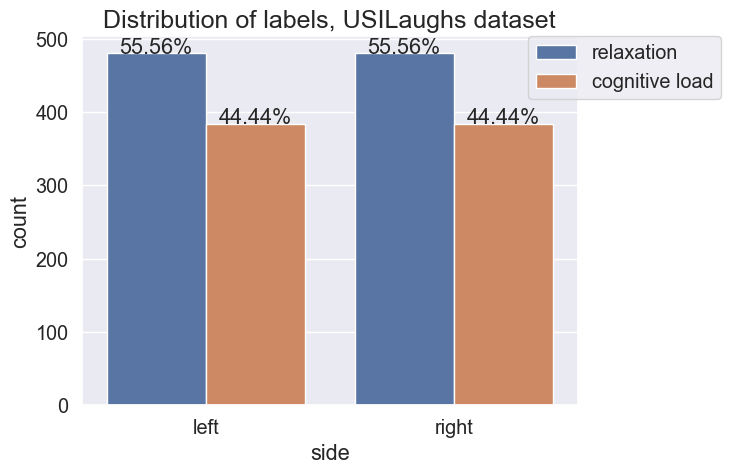

In [8]:
counts = get_labels_counts(labels_left, labels_right, ['relaxation', 'cognitive load'])
plot_binary_labels(
    counts=counts,
    title="Distribution of labels, USILaughs dataset",
    dataset_name="usilaughs",
    output_folder="../visualizations/"
)


The distribution is almost balanced: as such, re-balancing should not be a large problem.

## Feature Extraction

In [44]:
features_left = Parallel(n_jobs=-1)(
    delayed(get_eda_features)(value) for value in (values_left)
)
features_right = Parallel(n_jobs=-1)(
    delayed(get_eda_features)(value) for value in (values_right)
)

features_left: ndarray = stack(features_left)
features_right: ndarray = stack(features_right)

labels_left: ndarray = stack(labels_left)
labels_right: ndarray = stack(labels_right)

groups_left: ndarray = stack(groups_left)
groups_right: ndarray = stack(groups_right)


/Users/leonardoalchieri/miniconda3/envs/laugh2/lib/python3.10/site-packages/neurokit2/eda/eda_peaks.py:130: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])
/Users/leonardoalchieri/miniconda3/envs/laugh2/lib/python3.10/site-packages/neurokit2/eda/eda_peaks.py:130: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])
/Users/leonardoalchieri/miniconda3/envs/laugh2/lib/python3.10/site-packages/neurokit2/eda/eda_peaks.py:130: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])
/Users/leonardoalchieri/miniconda3/envs/laugh2/lib/python3.10/site-packages/neurokit2/eda/eda_peaks.py:130: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])
/Users/leonardoalchieri/miniconda3/envs/laugh2/lib/python3.10/site-p

In [38]:
print(f"{features_left.shape=}")
print(f"{labels_left.shape=}")
print(f"{groups_left.shape=}")

features_left.shape=(864, 11)
labels_left.shape=(864,)
groups_left.shape=(864,)


In [39]:
eda_features_names: list[str] = [
    "min_feat",
    "max_feat",
    "mean_feat",
    "std_feat",
    "dynamic_range_feat",
    "slope_feat",
    "absolute_slope_feat",
    "first_derivetive_mean_feat",
    "first_derivative_std_feat",
    "number_of_peaks_feat",
    "peaks_amplitude_feat",
]

# Two-split analysis

In [12]:
from numpy import asarray
# I just have to change how the groups are made
# these are selected as those with performance bad on the left and right hand
low_performers: list[str] = ['s037', 's048', 's059', 's071', 's087', 's098']

groups_left = asarray(['high' if user not in low_performers else 'low' for user in groups_left ])
groups_right = asarray(['high' if user not in low_performers else 'low' for user in groups_right ])

## LOSO

In [76]:
model_selected: str = "DecisionTreeClassifier"
metrics_selected: str = 'Accuracy'
n_seeds_to_test_classifiers: int = 30

In [78]:
averaged_results_loso_lxlx, all_results_loso_lxlx = run_same_side_classifications(
    features_left, labels_left, groups_left, n_seeds_to_test_classifiers=n_seeds_to_test_classifiers, n_jobs=-1
)

Random states classifiers progress::   0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 35.94it/s]


In [79]:
averaged_results_loso_rxrx, all_results_loso_rxrx = run_same_side_classifications(
    features_right, labels_right, groups_right, n_seeds_to_test_classifiers=n_seeds_to_test_classifiers
)

Random states classifiers progress::   0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 37.12it/s]


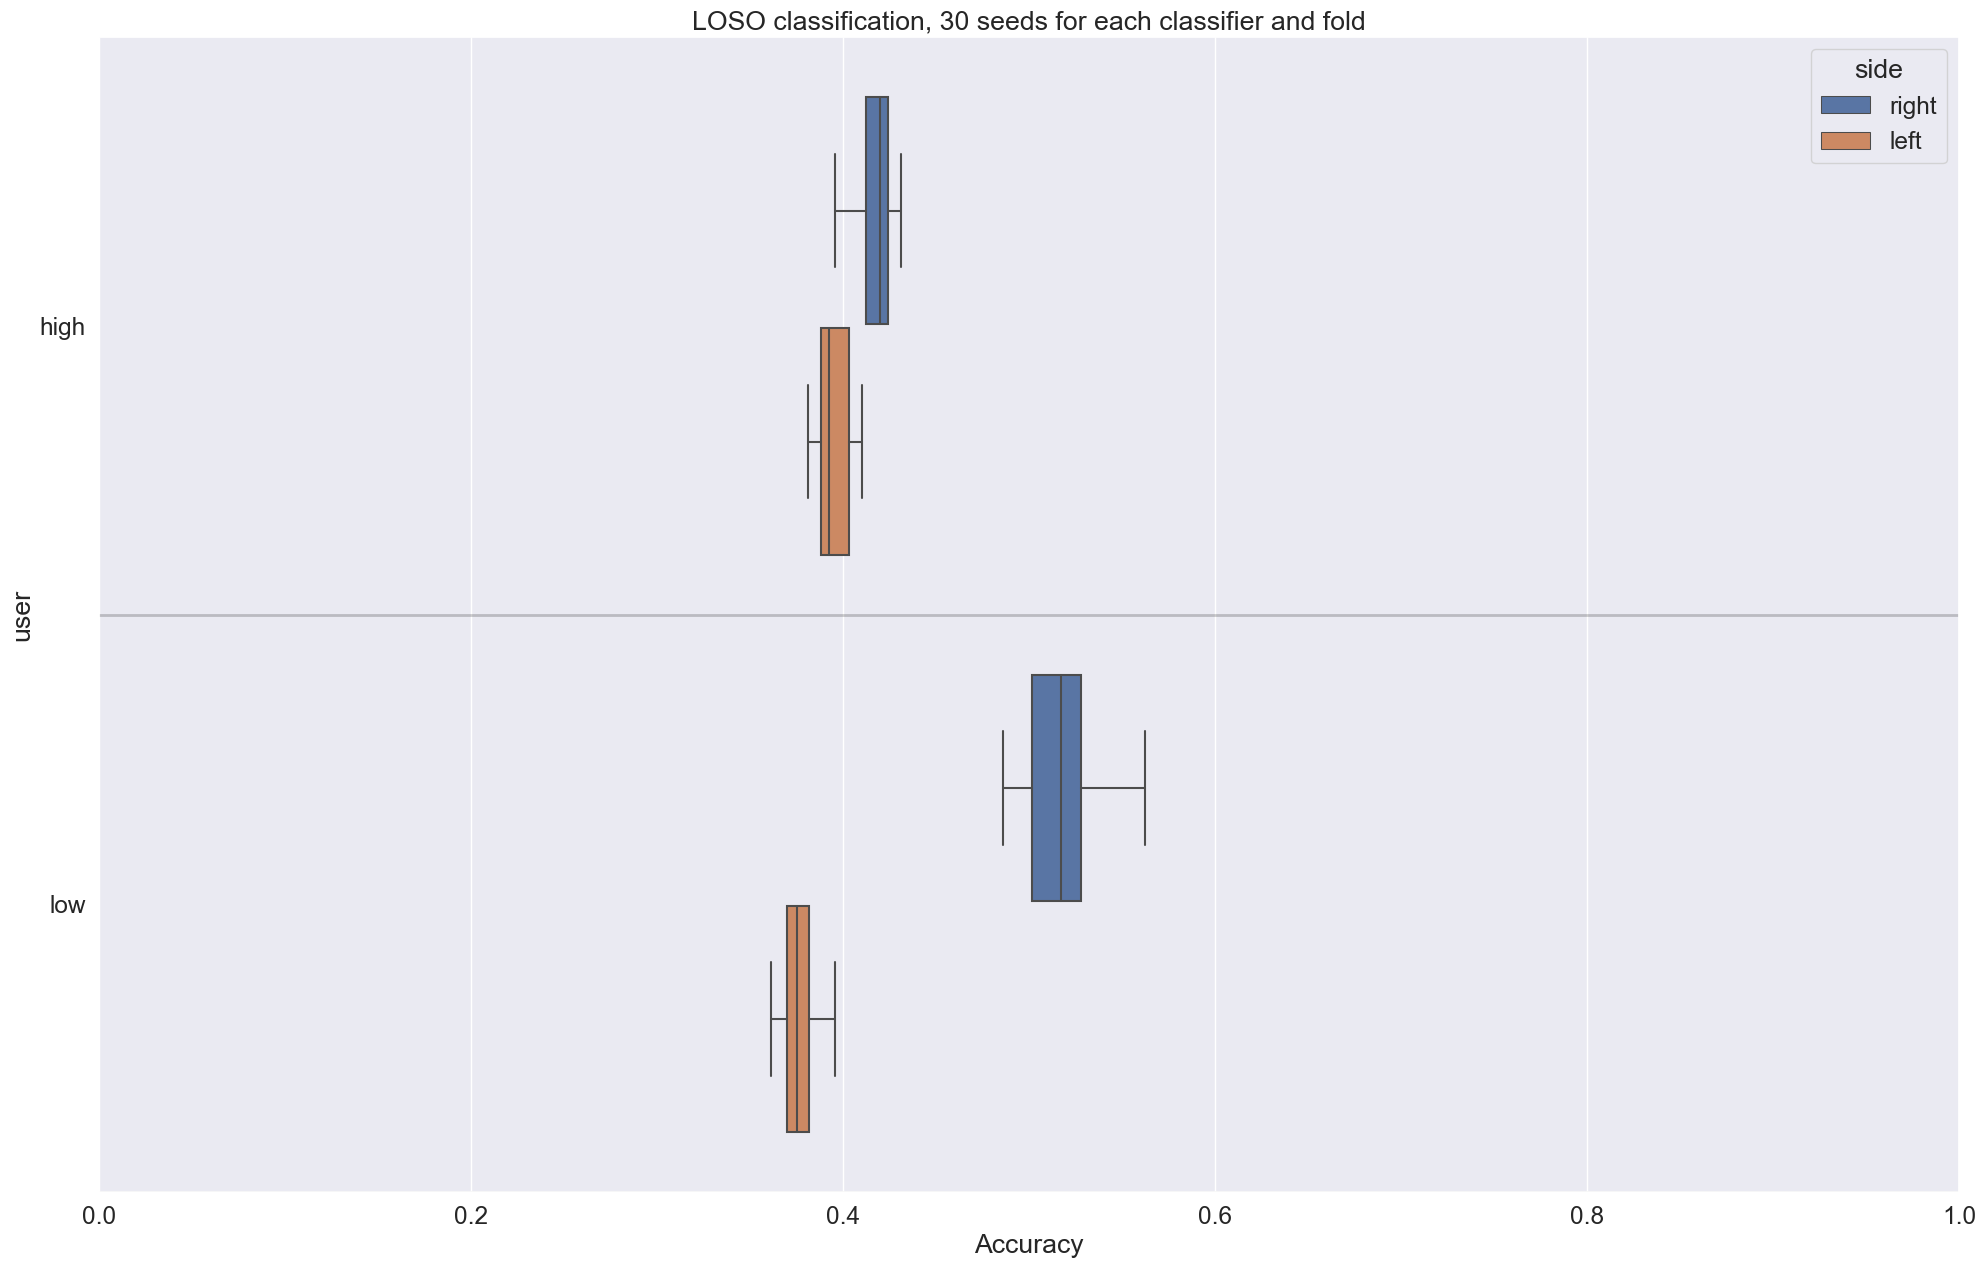

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator

selected_results_rxrx = [
    (single_result.loc[model_selected, metrics_selected], "right", single_result.columns.name)
    for seed_res in all_results_loso_rxrx
    for single_result in seed_res
]

selected_results_lxlx = [
    (single_result.loc[model_selected, metrics_selected], "left", single_result.columns.name)
    for seed_res in all_results_loso_lxlx
    for single_result in seed_res
]

plt.figure(figsize=(24, 15))
sns.set_context("paper")
sns.set(font_scale=1.6)
data_to_plot = DataFrame([*selected_results_rxrx, *selected_results_lxlx], columns=[metrics_selected, "side", "user"])
data_to_plot = data_to_plot.sort_values('user')
ax = sns.boxplot(data_to_plot, x=metrics_selected, y="user", hue='side')
ax.xaxis.grid(True)
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.grid(True, which='minor', linestyle='-', linewidth=2, color='black', alpha=0.2)
# ax.yaxis.grid(True, which='major', linestyle='-', linewidth=13, color='orange', alpha=0.3)
plt.title(f"LOSO classification, {n_seeds_to_test_classifiers} seeds for each classifier and fold")
ax.set_xlim(0., 1.0) 
plt.show()


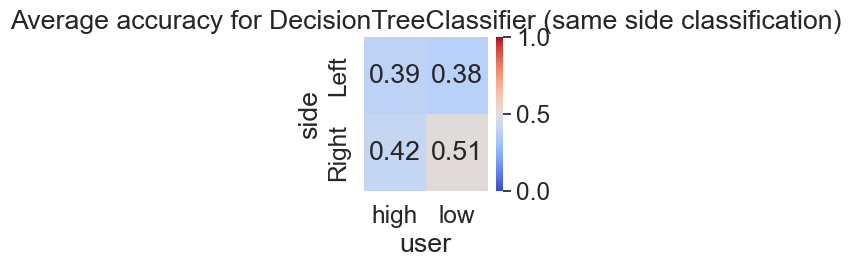

In [82]:
data_to_plot2 = data_to_plot.groupby(['user', 'side']).mean().unstack(level=[0]).T
data_to_plot2.index = data_to_plot2.index.droplevel(0)
data_to_plot2 = data_to_plot2.T
plt.figure(figsize=(len(data_to_plot2.columns), 2))
ax = sns.heatmap(data_to_plot2, 
            yticklabels=['Left', 'Right'],
            cmap='coolwarm', 
            annot=data_to_plot2.round(decimals=2),
            vmin=0, vmax=1,
            center=0.5,
            fmt="",)
plt.xticks(rotation=0, minor=True)
plt.title(f"Average accuracy for {model_selected} (same side classification)")
plt.show()

Just from this analysis, we can see that the LOSO performance between the two groups is very low. This result is indeed expected: we know there is some feature or element that differentiates the two groups. We just to identify which element this is. As such, we will train a Random Forest classifier again, as see how that goes.

## In-depth Random Forest

In [25]:
from sklearn.base import ClassifierMixin

def get_model(model_name: str) -> ClassifierMixin:
    return None
    
def train_to_inspect(x: ndarray, y: ndarray, folds: ndarray, group_to_leave_out: str, model: str = "RandomForestClassifier"):
    data = DataFrame(x, index=folds)
    data["label"] = y
    data_resampled = data.groupby(axis=0, level=0).apply(resampling)
    x_resampled = data_resampled.drop(columns=["label"], inplace=False).values
    y_resampled = data_resampled["label"].values
    folds_resampled = data_resampled.index.get_level_values(0).values
    
    x_train = x_resampled[folds_resampled != group_to_leave_out]
    y_train = y_resampled[folds_resampled != group_to_leave_out]
    x_test = x_resampled[folds_resampled == group_to_leave_out]
    y_test = y_resampled[folds_resampled == group_to_leave_out]
    
    if isinstance(model, str):
        model = get_model(model)
    elif isinstance(model, ClassifierMixin) or isinstance(model, LazyClassifier):
        pass
    else:
        raise ValueError(f"model must be a string or a ClassifierMixin. Received {type(model)}")
    
    # np.argwhere(np.isnan(x))
    if isinstance(model, LazyClassifier):
        model = model.provide_models(x_train, x_test, y_train, y_test)
        # model = model[0]
    else:
        model.fit(x_train, x_test, y_train, y_test)
    
    return model, x_train, x_test, y_train, y_test
    

### Left

In [15]:
from sklearn.ensemble import RandomForestClassifier
from lazypredict.Supervised import CLASSIFIERS

model, x_train, x_test, y_train, y_test = train_to_inspect(
    features_left,
    labels_left,
    groups_left,
    group_to_leave_out="low",
    model=LazyClassifier(
        random_state=42,
        predictions=True,
        classifiers=[el for el in CLASSIFIERS if el[0] == "DecisionTreeClassifier"],
    ),
)


'tuple' object has no attribute '__name__'
Invalid Classifier(s)


100%|██████████| 1/1 [00:00<00:00, 112.11it/s]


In [26]:

from sklearn.tree import export_graphviz
from sklearn import tree
import matplotlib.pyplot as plt

# tree_in_forest =  model['RandomForestClassifier'][-1].estimators_[0]
tree_in_forest = model['DecisionTreeClassifier'][-1]
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (20, 10))
tree.plot_tree(tree_in_forest,
               feature_names =eda_features_names, 
               class_names=['relaxation', 'cognitive load'],
               filled = True)
fig.savefig('../visualizations/distribution_labels_tree_left.pdf')
plt.close()

In [19]:
DataFrame([*x_test[10], y_test[10]], index=[*eda_features_names, 'label'])

,0
min_feat,1.12
max_feat,1.36
mean_feat,1.18
std_feat,0.05
dynamic_range_feat,0.24
slope_feat,-0.00
absolute_slope_feat,0.00
first_derivetive_mean_feat,-0.01
first_derivative_std_feat,0.05
number_of_peaks_feat,2.00


In [22]:
print(model['DecisionTreeClassifier'].predict(x_test[10].reshape(1, -1)))
print(y_test[10])

[1]
0


### Right

In [27]:
from sklearn.ensemble import RandomForestClassifier
from lazypredict.Supervised import CLASSIFIERS

model, x_train, x_test, y_train, y_test = train_to_inspect(
    features_right,
    labels_right,
    groups_right,
    group_to_leave_out="low",
    model=LazyClassifier(
        random_state=42,
        predictions=True,
        classifiers=[el for el in CLASSIFIERS if el[0] == "DecisionTreeClassifier"],
    ),
)


'tuple' object has no attribute '__name__'
Invalid Classifier(s)


100%|██████████| 1/1 [00:00<00:00, 137.73it/s]


In [28]:

from sklearn.tree import export_graphviz
from sklearn import tree
import matplotlib.pyplot as plt

# tree_in_forest =  model['RandomForestClassifier'][-1].estimators_[0]
tree_in_forest = model['DecisionTreeClassifier'][-1]
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (20, 10))
tree.plot_tree(tree_in_forest,
               feature_names =eda_features_names, 
               class_names=['relaxation', 'cognitive load'],
               filled = True)
fig.savefig('../visualizations/distribution_labels_tree_right.pdf')
plt.close()

In [29]:
DataFrame([*x_test[10], y_test[10]], index=[*eda_features_names, 'label'])

,0
min_feat,0.12
max_feat,0.21
mean_feat,0.18
std_feat,0.03
dynamic_range_feat,0.09
slope_feat,0.00
absolute_slope_feat,0.00
first_derivetive_mean_feat,0.01
first_derivative_std_feat,0.01
number_of_peaks_feat,2.00


In [30]:
print(model['DecisionTreeClassifier'].predict(x_test[10].reshape(1, -1)))
print(y_test[10])

[1]
0


# Visualize differences

In [49]:
from sklearn.cluster import DBSCAN
from numpy import concatenate, nan_to_num, mean
features_tot = concatenate((features_left, features_right), axis=0)
# clusters = DBSCAN(eps=0.9, min_samples=10, leaf_size=50, n_jobs=6).fit_predict(features_tot)

In [50]:
features_tot = DataFrame(features_tot, columns=eda_features_names)
features_tot = features_tot.fillna(features_tot.mean())

In [51]:
from sklearn.manifold import MDS
from plotly import express as px
from numpy import concatenate

random_state = 42
mds_tot = MDS(n_components=2, random_state=random_state).fit_transform(features_tot)
side = ["left"] * len(features_left) + ["right"] * len(features_right)
mds_tot = DataFrame(mds_tot, columns=["x", "y"])
mds_tot['side'] = side
mds_tot['user'] = concatenate([groups_left, groups_right], axis=0)
mds_tot['label'] = concatenate([labels_left, labels_right], axis=0)
mds_tot['label'] = mds_tot['label'].apply(lambda x: "cognitive load" if x == 1 else "relaxation")
mds_tot['cluster'] = asarray(groups_left.tolist() + groups_right.tolist())
mds_tot['cluster+label'] = mds_tot['cluster'].astype(str) + " " + mds_tot['label'].astype(str)

features_tot = features_tot.iloc[len(features_left):, :]
fig = px.scatter(
    data_frame=mds_tot,
    x="x",
    y="y",
    color="cluster+label",
    # symbol="cluster+label",
    hover_name="user",
    hover_data=["side", "label", "cluster"],
    title="MDS projection of features (both hands)",
    width=1000, height=800,
    # symbol_sequence=["circle", "cross"],
    color_discrete_sequence=['blue', 'red', 'green', 'orange'],
)
fig.show()
fig.write_html("../visualizations/mds_projection_labels.html")

In [48]:
from sklearn.manifold import TSNE
from plotly import express as px
from numpy import concatenate

random_state = 42
tsne_tot = TSNE(n_components=2, random_state=random_state, init='pca').fit_transform(features_tot)
side = ["left"] * len(features_left) + ["right"] * len(features_right)
tsne_tot = DataFrame(tsne_tot, columns=["x", "y"])
tsne_tot['side'] = side
tsne_tot['user'] = concatenate([groups_left, groups_right], axis=0)
tsne_tot['label'] = concatenate([labels_left, labels_right], axis=0)
tsne_tot['label'] = tsne_tot['label'].apply(lambda x: "cognitive load" if x == 1 else "relaxation")
tsne_tot['cluster'] = asarray(groups_left.tolist() + groups_right.tolist())
tsne_tot['cluster+label'] = tsne_tot['cluster'].astype(str) + " " + tsne_tot['label'].astype(str)

features_tot = features_tot.iloc[len(features_left):, :]
fig = px.scatter(
    data_frame=tsne_tot,
    x="x",
    y="y",
    color="cluster+label",
    # symbol="cluster+label",
    hover_name="user",
    hover_data=["side", "label", "cluster"],
    title="TSNE projection of features (both hands)",
    width=1000, height=800,
    # symbol_sequence=["circle", "cross"],
    color_discrete_sequence=['blue', 'red', 'green', 'orange'],
)
fig.show()
fig.write_html("../visualizations/tsen_projection_labels.html")

In [40]:
from sklearn.manifold import TSNE
from plotly import express as px
from numpy import concatenate

random_state = 42
features_left = DataFrame(features_left, columns=eda_features_names)
features_left = features_left.fillna(features_left.mean())
tsne_left = TSNE(n_components=2, random_state=random_state).fit_transform(features_left)
side = ["left"] * len(features_left)
tsne_left = DataFrame(tsne_left, columns=["x", "y"])
tsne_left['side'] = side
tsne_left['user'] = groups_left
tsne_left['label'] = labels_left
tsne_left['label'] = tsne_left['label'].apply(lambda x: "cognitive load" if x == 1 else "relaxation")
tsne_left['cluster'] = groups_left
tsne_left['cluster+label'] = tsne_left['cluster'].astype(str) + " " + tsne_left['label'].astype(str)

features_left = features_left.iloc[len(features_left):, :]
fig = px.scatter(
    data_frame=tsne_left,
    x="x",
    y="y",
    color="cluster+label",
    # symbol="cluster+label",
    hover_name="user",
    hover_data=["side", "label", "cluster"],
    title="TSNE projection of features (left hands)",
    width=1000, height=800,
    # symbol_sequence=["circle", "cross"],
    color_discrete_sequence=['blue', 'red', 'green', 'orange'],
)
fig.show()
fig.write_html("../visualizations/tsen_projection_labels_left.html")

In [41]:
from sklearn.manifold import TSNE
from plotly import express as px
from numpy import concatenate

random_state = 42
features_right = DataFrame(features_right, columns=eda_features_names)
features_right = features_right.fillna(features_right.mean())
tsne_right = TSNE(n_components=2, random_state=random_state).fit_transform(features_right)
side = ["right"] * len(features_right)
tsne_right = DataFrame(tsne_right, columns=["x", "y"])
tsne_right['side'] = side
tsne_right['user'] = groups_right
tsne_right['label'] = labels_right
tsne_right['label'] = tsne_right['label'].apply(lambda x: "cognitive load" if x == 1 else "relaxation")
tsne_right['cluster'] = groups_right
tsne_right['cluster+label'] = tsne_right['cluster'].astype(str) + " " + tsne_right['label'].astype(str)

features_right = features_right.iloc[len(features_right):, :]
fig = px.scatter(
    data_frame=tsne_right,
    x="x",
    y="y",
    color="cluster+label",
    # symbol="cluster+label",
    hover_name="user",
    hover_data=["side", "label", "cluster"],
    title="TSNE projection of features (right hand)",
    width=1000, height=800,
    # symbol_sequence=["circle", "cross"],
    color_discrete_sequence=['blue', 'red', 'green', 'orange'],
)
fig.show()
fig.write_html("../visualizations/tsen_projection_labels_right.html")

In [42]:
from sklearn.manifold import TSNE
from plotly import express as px
from numpy import concatenate

random_state = 42
features_right = DataFrame(features_right, columns=eda_features_names)
features_right = features_right.fillna(features_right.mean())
tsne_right = TSNE(n_components=2, random_state=random_state).fit_transform(features_right)
side = ["right"] * len(features_right)
tsne_right = DataFrame(tsne_right, columns=["x", "y"])
tsne_right['side'] = side
tsne_right['user'] = groups_right
tsne_right['label'] = labels_right
tsne_right['label'] = tsne_right['label'].apply(lambda x: "cognitive load" if x == 1 else "relaxation")
tsne_right['cluster'] = groups_right
tsne_right['cluster+label'] = tsne_right['cluster'].astype(str) + " " + tsne_right['label'].astype(str)

features_right = features_right.iloc[len(features_right):, :]
fig = px.scatter(
    data_frame=tsne_right,
    x="x",
    y="y",
    color="cluster+label",
    # symbol="cluster+label",
    hover_name="user",
    hover_data=["side", "label", "cluster"],
    title="TSNE projection of features (right hand)",
    width=1000, height=800,
    # symbol_sequence=["circle", "cross"],
    color_discrete_sequence=['blue', 'red', 'green', 'orange'],
)
fig.show()
fig.write_html("../visualizations/tsen_projection_labels_right.html")

ValueError: perplexity must be less than n_samples

# Distribution of features across groups

In [13]:
features_left_group_low = features_left[groups_left == 'low']
features_left_group_high = features_left[groups_left == 'high']

features_right_group_low = features_right[groups_right == 'low']
features_right_group_high = features_right[groups_right == 'high']

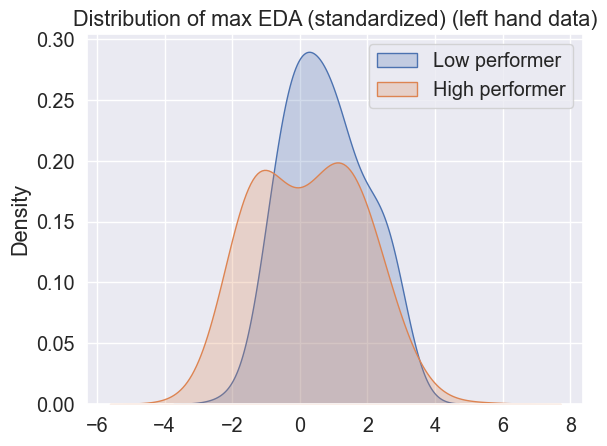

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.kdeplot(features_left_group_low[:,1], bw=0.5, label='Low performer', fill=True)
sns.kdeplot(features_left_group_high[:,1], bw=0.5, label='High performer', fill=True)
plt.legend()
plt.title("Distribution of max EDA (standardized) (left hand data)")
plt.show()

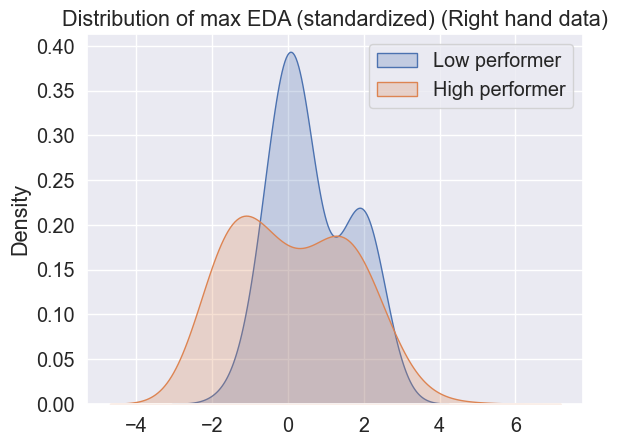

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.kdeplot(features_right_group_low[:,1], bw=0.5, label='Low performer', fill=True)
sns.kdeplot(features_right_group_high[:,1], bw=0.5, label='High performer', fill=True)
plt.legend()
plt.title("Distribution of max EDA (standardized) (Right hand data)")
plt.show()

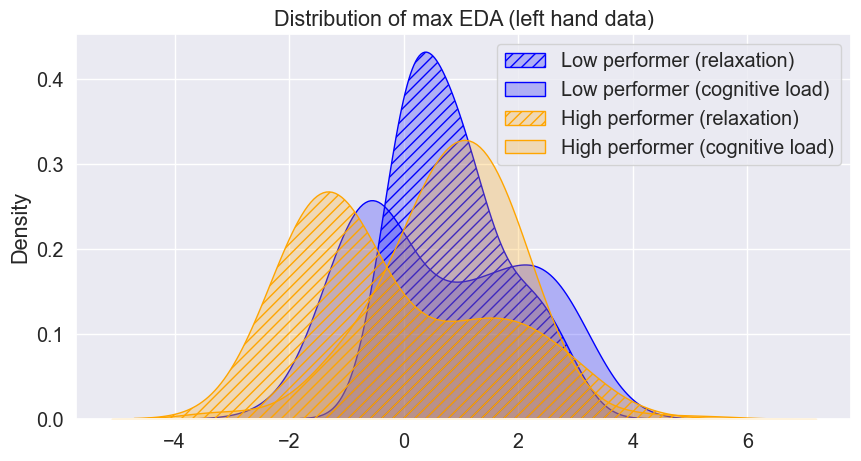

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
features_left_group_low_relaxation = features_left_group_low[labels_left[groups_left == 'low'] == 0]
features_left_group_low_cognitive = features_left_group_low[labels_left[groups_left == 'low'] == 1]
features_left_group_high_relaxation = features_left_group_high[labels_left[groups_left == 'high'] == 0]
features_left_group_high_cognitive = features_left_group_high[labels_left[groups_left == 'high'] == 1]

plt.figure(figsize=(10, 5))
sns.kdeplot(features_left_group_low_relaxation[:,1], bw=0.5, label='Low performer (relaxation)', fill=True, color='blue', hatch='///')
sns.kdeplot(features_left_group_low_cognitive[:,1], bw=0.5, label='Low performer (cognitive load)', fill=True, color='blue')
sns.kdeplot(features_left_group_high_relaxation[:,1], bw=0.5, label='High performer (relaxation)', fill=True, color='orange', hatch='///')
sns.kdeplot(features_left_group_high_cognitive[:,1], bw=0.5, label='High performer (cognitive load)', fill=True, color='orange')
plt.legend()
plt.title("Distribution of max EDA (left hand data)")
plt.show()

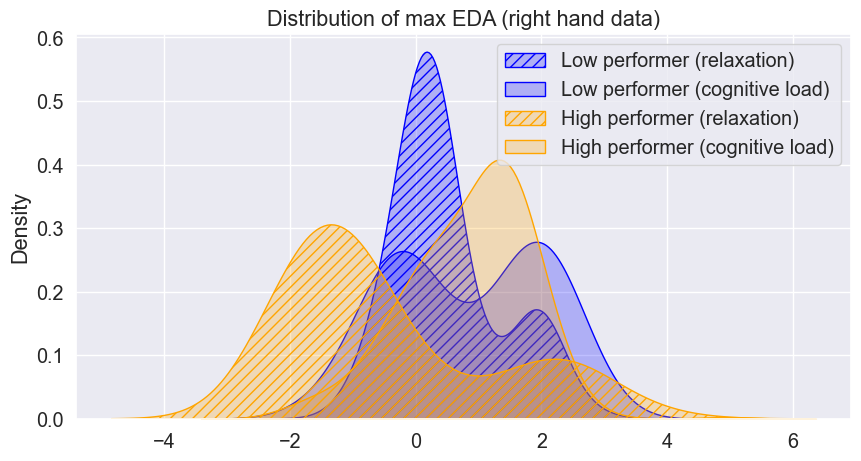

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
features_right_group_low_relaxation = features_right_group_low[labels_right[groups_right == 'low'] == 0]
features_right_group_low_cognitive = features_right_group_low[labels_right[groups_right == 'low'] == 1]
features_right_group_high_relaxation = features_right_group_high[labels_right[groups_right == 'high'] == 0]
features_right_group_high_cognitive = features_right_group_high[labels_right[groups_right == 'high'] == 1]

plt.figure(figsize=(10, 5))
sns.kdeplot(features_right_group_low_relaxation[:,1], bw=0.5, label='Low performer (relaxation)', fill=True, color='blue', hatch='///')
sns.kdeplot(features_right_group_low_cognitive[:,1], bw=0.5, label='Low performer (cognitive load)', fill=True, color='blue')
sns.kdeplot(features_right_group_high_relaxation[:,1], bw=0.5, label='High performer (relaxation)', fill=True, color='orange', hatch='///')
sns.kdeplot(features_right_group_high_cognitive[:,1], bw=0.5, label='High performer (cognitive load)', fill=True, color='orange')
plt.legend()
plt.title("Distribution of max EDA (right hand data)")
plt.show()

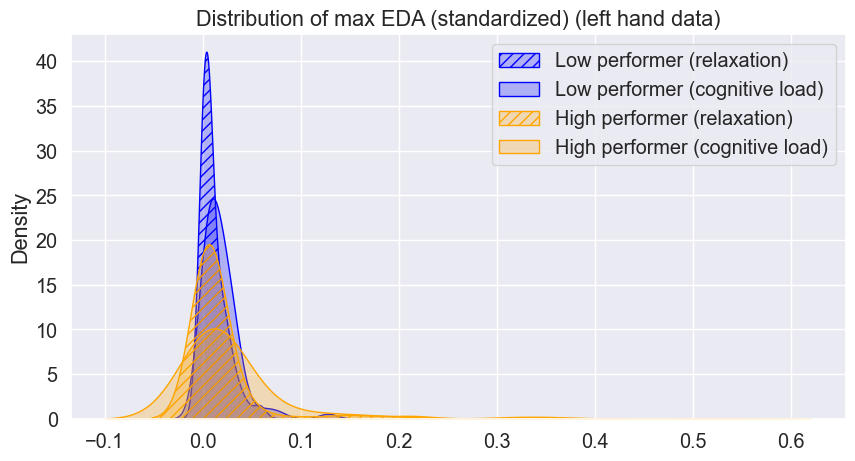

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
features_left_group_low_relaxation = features_left_group_low[labels_left[groups_left == 'low'] == 0]
features_left_group_low_cognitive = features_left_group_low[labels_left[groups_left == 'low'] == 1]
features_left_group_high_relaxation = features_left_group_high[labels_left[groups_left == 'high'] == 0]
features_left_group_high_cognitive = features_left_group_high[labels_left[groups_left == 'high'] == 1]

plt.figure(figsize=(10, 5))
sns.kdeplot(features_left_group_low_relaxation[:,8], bw=0.5, label='Low performer (relaxation)', fill=True, color='blue', hatch='///')
sns.kdeplot(features_left_group_low_cognitive[:,8], bw=0.5, label='Low performer (cognitive load)', fill=True, color='blue')
sns.kdeplot(features_left_group_high_relaxation[:,8], bw=0.5, label='High performer (relaxation)', fill=True, color='orange', hatch='///')
sns.kdeplot(features_left_group_high_cognitive[:,8], bw=0.5, label='High performer (cognitive load)', fill=True, color='orange')
plt.legend()
plt.title("Distribution of max EDA (standardized) (left hand data)")
plt.show()

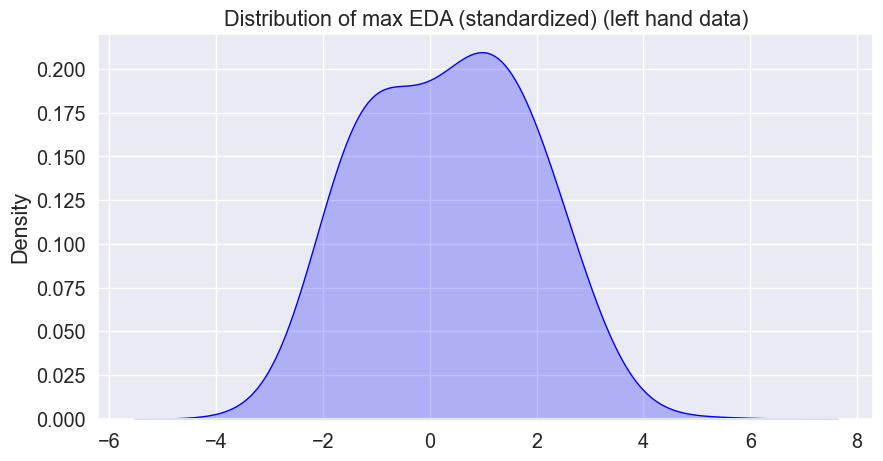

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.kdeplot(features_left[:,1], bw=0.5, fill=True, color='blue')
plt.title("Distribution of max EDA (standardized) (left hand data)")
plt.show()